<a href="https://colab.research.google.com/github/Ryo0326-hub/Ryo0326-hub/blob/main/Microsoft_prediction_simple_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install numpy pandas matplotlib scikit-learn tensorflow keras yfinance


In [8]:
import yfinance as yf

# Properly download data
msft = yf.download('MSFT', start='2010-01-01', end='2025-03-27')

# Reset index properly
msft.reset_index(inplace=True)

# Save CSV clearly
msft.to_csv('msft_stock_data.csv', index=False)

[*********************100%***********************]  1 of 1 completed


                         Close                High                 Low  \
Date                                                                     
NaT                       MSFT                MSFT                MSFT   
2010-01-04   23.25405502319336  23.366756131328316  22.983571217211594   
2010-01-05  23.261566162109375  23.366755100390442   23.02113675987656   
2010-01-06  23.118810653686523   23.35172644339226   22.93097501581076   
2010-01-07  22.878385543823242  23.066221216816626  22.683036271941425   

                          Open    Volume  
Date                                      
NaT                       MSFT      MSFT  
2010-01-04  23.006112012067522  38409100  
2010-01-05  23.178919450762017  49749600  
2010-01-06  23.201457359862772  58182400  
2010-01-07  23.013626024597613  50559700  
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object


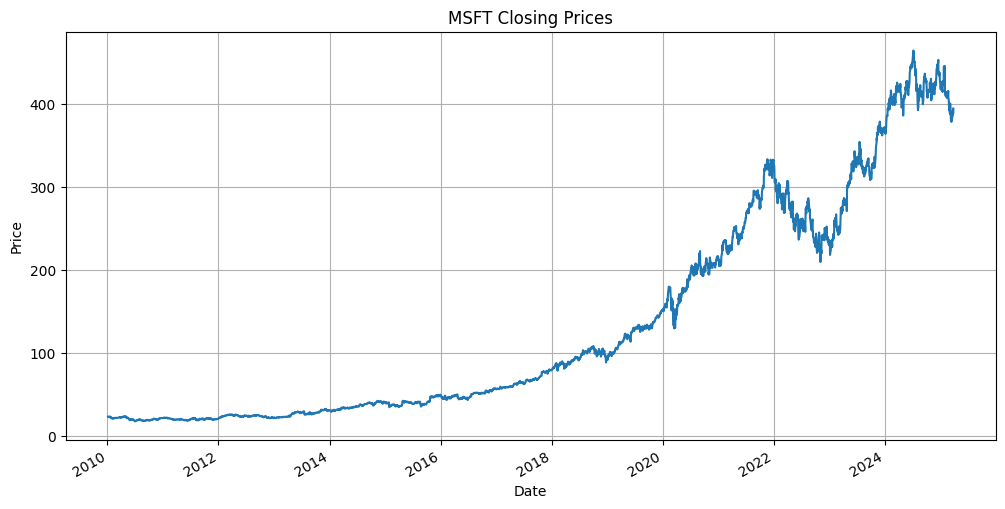

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data cleanly
df = pd.read_csv('msft_stock_data.csv', index_col='Date', parse_dates=['Date'])

# Verify your data is numeric and correctly loaded
print(df.head())
print(df.dtypes)

# Ensure numeric types explicitly (optional safety)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop any rows where Close is NaN (just in case)
df.dropna(subset=['Close'], inplace=True)

# Plotting should now work perfectly
df['Close'].plot(title='MSFT Closing Prices', figsize=(12,6))
plt.ylabel('Price')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [10]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,23.254055,23.366756131328316,22.983571217211594,23.006112012067522,38409100
2010-01-05,23.261566,23.366755100390442,23.02113675987656,23.178919450762017,49749600
2010-01-06,23.118811,23.35172644339226,22.93097501581076,23.201457359862772,58182400
2010-01-07,22.878386,23.066221216816626,22.683036271941425,23.013626024597613,50559700
2010-01-08,23.036163,23.201458181355395,22.7205993899508,22.750653780949705,51197400


In [11]:
#Returns & Lagged Features
df['Return'] = df['Close'].pct_change()
df['Lag_1'] = df['Return'].shift(1)
df['Lag_2'] = df['Return'].shift(2)
df['Lag_3'] = df['Return'].shift(3)

In [12]:
#Technical Indicators (Moving Averages)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['RSI'] = 100 - (100 / (1 + df['Return'].rolling(14).apply(lambda x: x[x>0].sum()/abs(x[x<0].sum()))))

In [15]:
#Dropping NA values:
df.dropna(inplace=True)

In [17]:
#Normalization and Train-Test split:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'MA10', 'MA50', 'RSI', 'Volume']])

train_size = int(len(scaled_data)*0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [18]:
#Creating Sequences (sliding window):
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [21]:
#Building an LSTM Model:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
#Training the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 7.0137e-04 - val_loss: 0.0051
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.8240e-04 - val_loss: 7.6855e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 4.6288e-04 - val_loss: 0.0011
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.6612e-04 - val_loss: 0.0010
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 4.7740e-04 - val_loss: 9.3959e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 4.4210e-04 - val_loss: 5.7329e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 3.7035e-04 - val_loss: 4.8805e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 3.8993e-04 - val_loss: 5.2545e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.2766e-04 - val_loss: 0.0010
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.2349e-04 - val_loss: 5.4303e-04

In [24]:
#Prediction and Reverse Scaling:
y_pred = model.predict(X_test)

# Reverse scaling
y_pred_scaled = scaler.inverse_transform(np.concatenate(
    [y_pred, np.zeros((len(y_pred), scaled_data.shape[1]-1))], axis=1))[:,0]

y_true_scaled = scaler.inverse_transform(np.concatenate(
    [y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))], axis=1))[:,0]

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


In [25]:
#Evaluating Performance
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_true_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_scaled, y_pred_scaled)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

RMSE: 63.233157990628364
MAE: 55.0328510976813


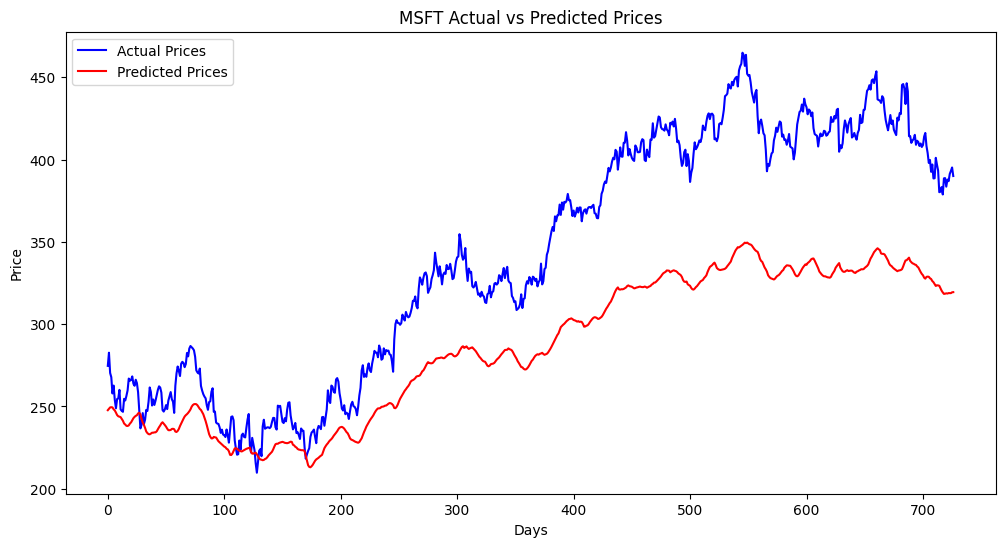

In [28]:
#Plotting Actual vs Predicted:
plt.figure(figsize=(12,6))
plt.plot(y_true_scaled, label='Actual Prices', color='blue')
plt.plot(y_pred_scaled, label='Predicted Prices', color='red')
plt.title('MSFT Actual vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

**Interpretation of Results**
The model has learned the overall direction of trends but isn't capturing the volatility and sharp increases or decreases effectively. This phenomenon is common in simple LSTM-based models predicting stock prices.

**What went well:**
The model identifies broader trends (upward or downward) quite accurately. It smoothly captures longer-term patterns.